In [1]:
from pyscf import gto, scf, fci, mcscf
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
import os
from qiskit import transpile
from qiskit_aer import AerSimulator, AerProvider
from math import comb
import time
import numpy as np
from scipy.sparse import csr_matrix


from scipy.sparse.linalg import eigsh
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
#service = QiskitRuntimeService()
#backend = service.backend("ibm_fez")
backend = AerSimulator(method = "statevector",noise_model=None)

In [3]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
    if mapper_name == "JW":
        mapper = JordanWignerMapper()
    if mapper_name == "Pa":
        mapper = ParityMapper(num_particles=problem.num_particles)
    if mapper_name == "BK":
        mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(second_q_op)
    return qubit_op , mapper
    # 고전값 비교용 FCI 
    # H2 인경우로만 해뒀고, 거리 주면 에너지 계산할 수 있음. 
    
def hamming_distance(state1, state2):
    """Number of differing bits"""
    return sum(c1 != c2 for c1, c2 in zip(state1, state2))

def str_to_bitstate(state_str):
    """
    문자열 ket 상태 "0101..." → int로 변환.
    문자열 왼쪽이 큐빗 N-1, 오른쪽이 큐빗0이라고 가정.
    """
    return int(state_str, 2)

def bitstate_to_str(state_int, n_qubits):
    """
    int ket 상태 → n_qubits 길이의 이진 문자열로 변환.
    """
    return format(state_int, f'0{n_qubits}b')

def apply_pauli_string_bits(state, pauli_string, n_qubits):
    """
    state: int로 표현된 ket. ex) 0b0101 → 5
    pauli_string: 문자열. 예) "XIZY..."
    n_qubits: 큐빗 수
    
    Returns:
        (new_state: int, phase: complex)
    """
    phase = 1.0
    # 큐빗0을 오른쪽(Little Endian)으로 가정하므로, pauli_string은 오른쪽부터 큐빗0 → 왼쪽 큐빗N-1
    for i, p in enumerate(reversed(pauli_string)):  # LSB부터 순회
        bit = (state >> i) & 1
        if p == 'I':
            continue
        elif p == 'Z':
            if bit:
                phase *= -1
        elif p == 'X':
            state ^= (1 << i)  # i번째 비트 flip
        elif p == 'Y':
            if bit:
                phase *= -1j
            else:
                phase *= 1j
            state ^= (1 << i)
    return state, phase

def apply_pauli_string(state_str, pauli_string):
    """
    state_str: "0101..." 형태의 ket 문자열 (왼쪽이 큐빗 N-1, 오른쪽이 큐빗0)
    pauli_string: "XIZY..." 형태의 파울리 연산 문자열
    
    Returns:
        (new_state_str, phase)
    """
    n_qubits = len(pauli_string)
    state_int = str_to_bitstate(state_str)
    new_state_int, phase = apply_pauli_string_bits(state_int, pauli_string, n_qubits)
    new_state_str = bitstate_to_str(new_state_int, n_qubits)
    return new_state_str, phase

def inner_product_pauli_hamiltonian(pauli_op, basis_bra_str, basis_ket_str):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.
    pauli_op: Qiskit's PauliSumOp 또는 pauli_op.to_list()를 지원하는 형태
    basis_bra_str, basis_ket_str: "0101..." 형태의 ket 문자열
    
    Returns: float (real part of <bra|H|ket>)
    """
    n_qubits = len(basis_bra_str)
    basis_bra_int = str_to_bitstate(basis_bra_str)
    basis_ket_int = str_to_bitstate(basis_ket_str)
    
    total = 0.0
    for pauli_string, coeff in pauli_op.to_list():
        new_state_int, phase = apply_pauli_string_bits(basis_ket_int, pauli_string, n_qubits)
        if new_state_int == basis_bra_int:
            total += coeff * phase
            
    return total.real

def project_hamiltonian(basis,hamiltonian):
    n = len(basis)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            basis_bra = basis[i]
            basis_ket = basis[j]
            inner_product = inner_product_pauli_hamiltonian(hamiltonian, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 

            #print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    return H 

def particle_count(s):
    n = len(s)
    half = n // 2
    left = s[:half].count('1')
    right = s[half:].count('1')
    return left, right

def flip_one_pair(s, zero_idx, one_idx):
    """
    문자열 s에서 zero_idx는 '0'이어야 하고 → '1'로 바꾸고,
    one_idx는 '1'이어야 하고 → '0'으로 바꿈
    """
    s = list(s)
    assert s[zero_idx] == '0', f"Index {zero_idx} is not 0"
    assert s[one_idx] == '1', f"Index {one_idx} is not 1"
    s[zero_idx] = '1'
    s[one_idx] = '0'
    return ''.join(s)

def one_step_states_constrained(s):
    """1번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    zeros = [i for i, c in enumerate(s) if c == '0']
    ones = [i for i, c in enumerate(s) if c == '1']
    target_left, target_right = particle_count(s)

    states = set()
    for zi in zeros:
        for oi in ones:
            if zi == oi:
                continue
            new_s = flip_one_pair(s, zi, oi)
            l, r = particle_count(new_s)
            if l == target_left and r == target_right:
                states.add(new_s)
    return states

def two_step_states_constrained(s):
    """2번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    step1 = one_step_states_constrained(s)
    states = set()
    for inter in step1:
        states.update(one_step_states_constrained(inter))
    states.discard(s)  # 자기 자신은 제외
    return states

def calc_total_space(n,k):
    alpha_spin_orbital =int(n/2)
    alpha_electron = int(k/2)
    dim = (comb(alpha_spin_orbital, alpha_electron))**2
    return dim
    

In [4]:
def Circuit_Preperation(hamiltonian, E_problem,mapper, which_ansatz):
    #헤밀토니안이랑 driver 주어지면, 회로 생성. 
    num_qubits = hamiltonian.num_qubits
    print("num_qubits:" , num_qubits)
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
    if which_ansatz == "uccsd":
        ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state,generalized=True)
    elif which_ansatz == "twolocal": 
        ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state)
    else : 
        print("ansatz 입력 틀림 uccsd or twolocal ")
    return ansatz

def sampling_Filtering(ansatz, parameter, backend, num_particles):
    # 측정해서 spin이랑 그런거 맞는거만 필터링
    global convergence_state
    global cost_history_dict 
    global repulsion
    global banned_state
    time2 = time.time()

    params = ansatz.parameters 
    param_dict = dict(zip(params, parameter))
    qc = ansatz.assign_parameters(param_dict)
    qc.measure_all()

    job = backend.run(transpile(qc, backend), shots=5000)
    result = job.result()

    # Counts 얻기
    counts = result.get_counts(qc)
    total_shots = sum(counts.values())
    probs = [(bitstring, count / total_shots) for bitstring, count in counts.items()]
    print("sampled_space : " , len(probs))

    all_basis = []
    all_prob = []

    for bitstring, prob in probs:
        count_ones = bitstring.count('1')
        half = len(bitstring) // 2
        left_ones = bitstring[:half].count('1')
        right_ones = bitstring[half:].count('1')
        if left_ones+right_ones == np.sum(num_particles):
            all_basis.append(bitstring)
            all_prob.append(prob)
    all_basis = np.array(all_basis)
    #print(len(all_basis))
    all_prob = np.array(all_prob)
        # ... 코드 ...
    
    print("-----------------------")
    print(f"Sampling : {time.time() - time2:.6f}초")
    return all_basis

def construct_c_i(all_basis, C_i_1):
    c_i = all_basis | C_i_1
    return c_i    

def screening(all_basis,hamiltonian,k):
    time2 = time.time()
    screened_space = []
    H = project_hamiltonian(all_basis,hamiltonian)
    print(f"Screening_projection : {time.time() - time2:.6f}초")
    
    time3 = time.time()
    eigenvalue, eigenvector = eigsh(H, k=1, tol=1e-4, which='SA')  # SA: smallest algebraic
    print(f"Screening_Digonalization: {time.time() - time3:.6f}초")

    v0 = eigenvector[:, 0]  # 가장 작은 고유값에 대응하는 고유벡터
    indices = np.argsort(np.abs(v0))[-k:]  # 절댓값 기준으로 큰 순서대로 k개
    important_states = indices[::-1]  # 큰 순서대로 정렬
    
    #print(important_states)
    for idx in important_states:
        screened_basis = all_basis[idx]
        screened_space.append(screened_basis)
        
    H_sub = H[np.ix_(important_states, important_states)]
    print(f"Screening : {time.time() - time2:.6f}초")
    
    return screened_space,  H_sub


def energy_calc(screened_space,hamiltonian):
    time2 = time.time()
    mat = project_hamiltonian(screened_space,hamiltonian)  
    eigvals, eigvecs = eigsh(mat, k=1, which='SA')
    # 가장 작은 고윳값
    smallest_eigenvalue = eigvals[0]
    smallest_eigvec = eigvecs[0]
    #print("가장 작은 고윳값:", smallest_eigenvalue+repulsion)
    print(f"energy calc: {time.time() - time2:.6f}초")
    
    return smallest_eigenvalue, smallest_eigvec

def post_screening(smallest_eigvec, screened_space, eps):
    time2 = time.time()
    low_contrib_space = []
    low_contrib_indices = np.where(np.abs(smallest_eigvec) < eps)[0]
    for idx in low_contrib_indices:
        low_contrib_state = screened_space[idx]
        low_contrib_space.append(low_contrib_state)
    post_screened_space = list(set(screened_space) - set(low_contrib_space))
    print(f"post screening: {time.time() - time2:.6f}초")
    return post_screened_space 

def classical_expansion(smallest_eigvec,screened_space,post_screened_space):
    time2 = time.time()
    max_index = np.argmax(np.abs(smallest_eigvec))
    s = screened_space[max_index]
    s1_constrained = one_step_states_constrained(s)
    s2_constrained = two_step_states_constrained(s)
    #print(s1_constrained)
    #print(s2_constrained)
    excitation_expansion = s1_constrained.union(s2_constrained)
    total_expansion = excitation_expansion.union(post_screened_space)    
    print(f"calssical expansion: {time.time() - time2:.6f}초")
    return list(total_expansion), list(excitation_expansion)

In [5]:
class CostWithHistoryList:
    def __init__(self, hamiltonian, ansatz, backend, num_electrons, num_determinant, eps, num_particles,core,repulsion ,threshold=1e-4):

        self.prev_list = []
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz
        self.backend = backend
        self.num_electrons = num_electrons
        self.num_determinant = num_determinant
        self.eps = eps
        self.num_particles = num_particles
        self.core =core
        self.repulsion = repulsion
        # 저장소
        self.ith_space = None
        self.expanded_space = None
        self.energy_history = []
        self.iteration = 0
        self.threshold = threshold

        # 수렴 추적용
        self.prev_energies = []
        self.converged_count = 0

    def __call__(self, parameter):
        time2 = time.time()
        current_list = list(self.compute_current_list(parameter))
        self.prev_list = list(set(self.prev_list + current_list))

        # 에너지 계산
        print("Constructed_space",len(self.prev_list))
        
        if len(self.prev_list) > self.num_determinant: 
            screened_space, Hsub = screening(self.prev_list, self.hamiltonian, self.num_determinant)
            print("screened_space",len(screened_space))
            time2 = time.time()
            eigvals, eigvecs = eigsh(Hsub, k=1, which='SA')
            # 가장 작은 고윳값
            Energy = eigvals[0]
            ground_state = eigvecs[0]
            #print("가장 작은 고윳값:", smallest_eigenvalue+repulsion)
            print(f"energy calc: {time.time() - time2:.6f}초")
        else : 
            screened_space = self.prev_list
            print("screened_space",len(screened_space))
            Energy, ground_state = energy_calc(screened_space, self.hamiltonian)
        
        post_screened_space = post_screening(ground_state, screened_space, self.eps)
        

        # 저장
        self.ith_space, self.expanded_space = classical_expansion(ground_state,screened_space,post_screened_space)
        self.iteration += 1
        self.energy_history.append(Energy)

        # 에너지 변화량 추적
        if self.prev_energies:
            delta = abs(Energy - self.prev_energies[-1])
            if delta < self.threshold:
                self.converged_count += 1
            else:
                self.converged_count = 0

            if self.converged_count >= 3:
        
                print(f"🔚 조기 종료: ΔE < {self.threshold} 가 3회 연속 만족됨.")
                raise StopIteration

        self.prev_energies.append(Energy)

        print(f"each iteration: {time.time() - time2:.6f}초")
        print(f"Iter {self.iteration}: Energy = {Energy +self.repulsion + self.core:.6f}")
        print("-----------------------")
        
        return Energy

    def compute_current_list(self, parameter):
        return sampling_Filtering(self.ansatz, parameter, self.backend, self.num_particles)

In [6]:
def HIVQE(E_problem, k, E_FCI ,which_as = True, fig = True):
    num_spin_orbital = 2*E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    # Transformer 적용
    #E_problem = active_transformer.transform(problem)
    # 여기는 이후, As_transformer 로 변경. 
    fermionic_hamiltonian = E_problem.hamiltonian
    repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
    if which_as == True:
        core = fermionic_hamiltonian.constants['ActiveSpaceTransformer']
    else:
        core = 0
    second_q_op = fermionic_hamiltonian.second_q_op()
    hamiltonian,mapper = fermion_to_qubit(E_problem, second_q_op, "JW")

    time1 = time.time() #헤밀토니안 구성
    # ... 코드 ...
    eps = 10**(-5)
    Chem_accuracy = 0.0016
    ansatz = Circuit_Preperation(hamiltonian, E_problem, mapper, "uccsd")
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)

    cost_func = CostWithHistoryList(
        hamiltonian=hamiltonian,
        ansatz=ansatz,
        backend=backend,
        num_electrons=num_electrons,
        num_determinant=k,
        eps=eps,
        num_particles = num_particles,
        core = core,
        repulsion= repulsion
    )


    try:
        res = minimize(
            cost_func,
            x0,
            method="cobyla",
            options={"maxiter": 20, "disp": True}
        )
        
    except StopIteration:
        print("⚠️ Optimization stopped early due to convergence criteria.")
        
    if fig == True:   
        if which_as == True:
            plt.plot(cost_func.energy_history+core+repulsion, marker='x', linestyle='-' ,label = "HIVQE")
        else:
            plt.plot(cost_func.energy_history+repulsion, marker='x', linestyle='-' ,label = "HIVQE")
            
        #plt.axhline(E_HF, label = "HF")
        plt.axhline(E_FCI, color ='r',ls= '--',label = "Numpy_minimum_eigensolver")
        plt.ticklabel_format(style='plain', axis='y')  # 과학적 표기 X
        plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # 일반 숫자 포맷
        plt.gca().ticklabel_format(useOffset=False, style='plain')  # 진짜 값으로
        plt.title("Energy")
        plt.xlabel("Iteration")
        plt.ylabel("Energy(hartree)")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
        plt.grid()
        plt.show()
        
        if which_as == True:
            error = cost_func.energy_history + core + repulsion - E_FCI
        else:
            error = cost_func.energy_history  + repulsion - E_FCI    
        for i in range(len(error)) : 
            err = error[i]
            if err < 10**(-7) : 
                error[i]= 10**(-7)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열, 가로 배치

        # 좌측: 일반 스케일 그래프
        axes[0].plot(error, marker='x', linestyle='-', label="HIVQE")
        axes[0].axhline(Chem_accuracy, color='red', ls='--', label='chemical accuracy')
        axes[0].set_title("error")
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel("Error (hartree)")
        axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
        axes[0].grid()

        # 우측: 로그 스케일 그래프
        axes[1].plot(error, marker='x', linestyle='-', label="HIVQE")
        axes[1].axhline(Chem_accuracy, color='red', ls='--', label='chemical accuracy')
        axes[1].set_yscale("log")
        axes[1].set_title("error (log scale)")
        axes[1].set_xlabel("Iteration")
        axes[1].set_ylabel("Error (hartree) [log scale]")
        axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
        axes[1].grid()
    
    energy = cost_func.energy_history[-1] +repulsion + core
    return energy

In [7]:
start = time.time()

atoms = ["Li", "H"]
basis = 'sto-3g'
dist = 1.6
coords = [(0,0,0), (dist,0,0)]
charge = 0
multiplicity = 1

Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 


num_spin_orbital = 2*E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons)
print(total_dim)

225


In [8]:
mol = gto.Mole()
mol.atom = 'Li 0 0 0; H 0 0 1.6'
mol.basis = 'sto-3g'
mol.spin = 0           # (2S), LiH는 closed-shell
mol.charge = 0
mol.build()

# 2. Hartree–Fock 계산 (reference wavefunction)
mf = scf.RHF(mol)
hf_energy = mf.kernel()

E_nuc = mol.energy_nuc()


# 3. FCI 계산
cisolver = fci.FCI(mol, mf.mo_coeff)
E_FCI, fci_vector = cisolver.kernel()
print(f"FCI Energy    = {E_FCI:.8f} Ha")

converged SCF energy = -7.86186476980865
FCI Energy    = -7.88232438 Ha


num_qubits: 12
sampled_space :  176
-----------------------
Sampling : 1.094935초
Constructed_space 176
Screening_projection : 58.349440초
Screening_Digonalization: 0.003448초
Screening : 58.353118초
screened_space 100
energy calc: 0.000964초
post screening: 0.000017초
calssical expansion: 0.000364초
each iteration: 0.001373초
Iter 1: Energy = -7.867355
-----------------------
sampled_space :  170
-----------------------
Sampling : 1.176291초
Constructed_space 190
Screening_projection : 68.021671초
Screening_Digonalization: 0.004199초
Screening : 68.026209초
screened_space 100
energy calc: 0.003401초
post screening: 0.000053초
calssical expansion: 0.000683초
each iteration: 0.004216초
Iter 2: Energy = -7.867360
-----------------------
sampled_space :  192
-----------------------
Sampling : 1.187404초
Constructed_space 213
Screening_projection : 84.781915초
Screening_Digonalization: 0.003146초
Screening : 84.785418초
screened_space 100
energy calc: 0.003104초
post screening: 0.000034초
calssical expansion: 0

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


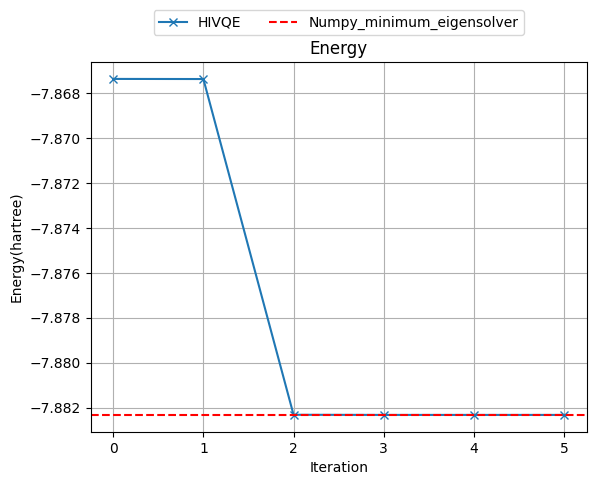

-7.88232437888349

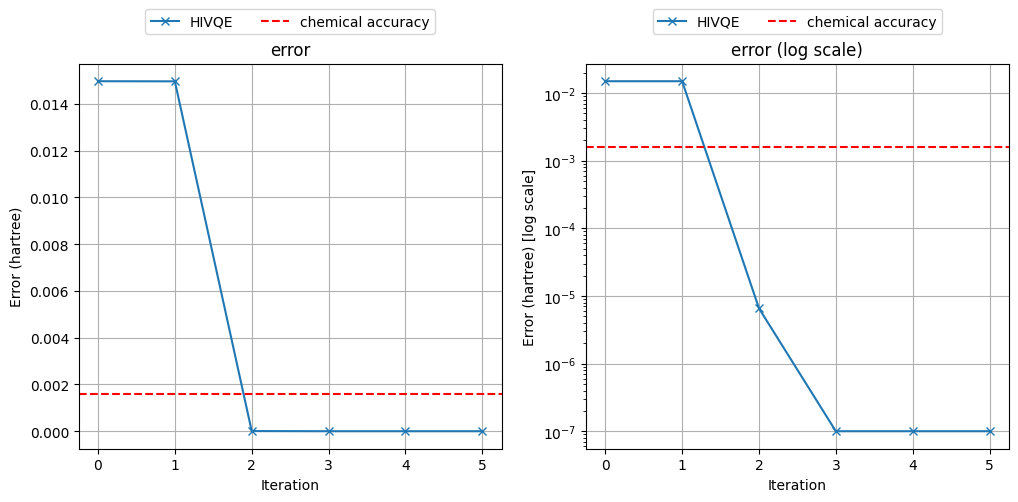

In [9]:
HIVQE(E_problem, 100, E_FCI, False, True)

num_qubits: 12
sampled_space :  188
-----------------------
Sampling : 1.119967초
Constructed_space 188
Screening_projection : 67.282825초
Screening_Digonalization: 0.002052초
Screening : 67.285118초
screened_space 30
energy calc: 0.001667초
post screening: 0.000017초
calssical expansion: 0.000360초
each iteration: 0.002082초
Iter 1: Energy = -5.879663
-----------------------
sampled_space :  192
-----------------------
Sampling : 1.193606초
Constructed_space 198
Screening_projection : 74.087325초
Screening_Digonalization: 0.002046초
Screening : 74.089632초
screened_space 30
energy calc: 0.001225초
post screening: 0.000025초
calssical expansion: 0.001006초
each iteration: 0.002350초
Iter 2: Energy = -5.879735
-----------------------
sampled_space :  186
-----------------------
Sampling : 1.161096초
Constructed_space 216
Screening_projection : 87.041298초
Screening_Digonalization: 0.005881초
Screening : 87.047460초
screened_space 30
energy calc: 0.001708초
post screening: 0.000027초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  183
-----------------------
Sampling : 1.065708초
Constructed_space 183
Screening_projection : 62.205774초
Screening_Digonalization: 0.000918초
Screening : 62.206865초
screened_space 30
energy calc: 0.000468초
post screening: 0.000012초
calssical expansion: 0.000354초
each iteration: 0.000858초
Iter 1: Energy = -6.527247
-----------------------
sampled_space :  178
-----------------------
Sampling : 1.197047초
Constructed_space 196
Screening_projection : 71.482293초
Screening_Digonalization: 0.005376초
Screening : 71.487928초
screened_space 30
energy calc: 0.001539초
post screening: 0.000029초
calssical expansion: 0.001056초
each iteration: 0.002715초
Iter 2: Energy = -6.528092
-----------------------
sampled_space :  186
-----------------------
Sampling : 1.200036초
Constructed_space 220
Screening_projection : 92.008394초
Screening_Digonalization: 0.003991초
Screening : 92.012632초
screened_space 30
energy calc: 0.001089초
post screening: 0.000014초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  185
-----------------------
Sampling : 1.060717초
Constructed_space 185
Screening_projection : 63.807403초
Screening_Digonalization: 0.002973초
Screening : 63.810643초
screened_space 30
energy calc: 0.001305초
post screening: 0.000028초
calssical expansion: 0.000976초
each iteration: 0.002387초
Iter 1: Energy = -6.873363
-----------------------
sampled_space :  192
-----------------------
Sampling : 1.156228초
Constructed_space 199
Screening_projection : 73.790111초
Screening_Digonalization: 0.003170초
Screening : 73.793498초
screened_space 30
energy calc: 0.001499초
post screening: 0.000026초
calssical expansion: 0.000947초
each iteration: 0.002554초
Iter 2: Energy = -6.903561
-----------------------
sampled_space :  184
-----------------------
Sampling : 1.210633초
Constructed_space 220
Screening_projection : 90.460605초
Screening_Digonalization: 0.005346초
Screening : 90.466163초
screened_space 30
energy calc: 0.001545초
post screening: 0.000026초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  177
-----------------------
Sampling : 1.107121초
Constructed_space 177
Screening_projection : 59.877933초
Screening_Digonalization: 0.002276초
Screening : 59.880428초
screened_space 30
energy calc: 0.001495초
post screening: 0.000026초
calssical expansion: 0.000936초
each iteration: 0.002522초
Iter 1: Energy = -7.170089
-----------------------
sampled_space :  169
-----------------------
Sampling : 1.273386초
Constructed_space 183
Screening_projection : 63.641770초
Screening_Digonalization: 0.000889초
Screening : 63.642784초
screened_space 30
energy calc: 0.000555초
post screening: 0.000011초
calssical expansion: 0.000355초
each iteration: 0.000948초
Iter 2: Energy = -7.170083
-----------------------
sampled_space :  168
-----------------------
Sampling : 1.187703초
Constructed_space 203
Screening_projection : 77.602776초
Screening_Digonalization: 0.001275초
Screening : 77.604418초
screened_space 30
energy calc: 0.000481초
post screening: 0.000018초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  194
-----------------------
Sampling : 1.141653초
Constructed_space 194
Screening_projection : 71.215813초
Screening_Digonalization: 0.003287초
Screening : 71.219329초
screened_space 30
energy calc: 0.001211초
post screening: 0.000025초
calssical expansion: 0.000972초
each iteration: 0.002281초
Iter 1: Energy = -7.361910
-----------------------
sampled_space :  192
-----------------------
Sampling : 1.241250초
Constructed_space 203
Screening_projection : 77.822850초
Screening_Digonalization: 0.002334초
Screening : 77.825660초
screened_space 30
energy calc: 0.001607초
post screening: 0.000045초
calssical expansion: 0.000937초
each iteration: 0.002702초
Iter 2: Energy = -7.361990
-----------------------
sampled_space :  194
-----------------------
Sampling : 1.220922초
Constructed_space 219
Screening_projection : 91.471987초
Screening_Digonalization: 0.001071초
Screening : 91.473326초
screened_space 30
energy calc: 0.000404초
post screening: 0.000015초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  185
-----------------------
Sampling : 1.062707초
Constructed_space 185
Screening_projection : 63.045046초
Screening_Digonalization: 0.001945초
Screening : 63.047201초
screened_space 30
energy calc: 0.001203초
post screening: 0.000025초
calssical expansion: 0.000929초
each iteration: 0.002220초
Iter 1: Energy = -7.503251
-----------------------
sampled_space :  186
-----------------------
Sampling : 1.225158초
Constructed_space 194
Screening_projection : 69.405585초
Screening_Digonalization: 0.001839초
Screening : 69.407634초
screened_space 30
energy calc: 0.001501초
post screening: 0.000024초
calssical expansion: 0.000928초
each iteration: 0.002524초
Iter 2: Energy = -7.503558
-----------------------
sampled_space :  173
-----------------------
Sampling : 1.174001초
Constructed_space 214
Screening_projection : 85.037240초
Screening_Digonalization: 0.034544초
Screening : 85.072043초
screened_space 30
energy calc: 0.005251초
post screening: 0.000034초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  181
-----------------------
Sampling : 1.127288초
Constructed_space 181
Screening_projection : 61.975386초
Screening_Digonalization: 0.003881초
Screening : 61.979483초
screened_space 30
energy calc: 0.007060초
post screening: 0.000016초
calssical expansion: 0.000361초
each iteration: 0.007474초
Iter 1: Energy = -7.599889
-----------------------
sampled_space :  181
-----------------------
Sampling : 1.185043초
Constructed_space 194
Screening_projection : 70.849425초
Screening_Digonalization: 0.002563초
Screening : 70.852214초
screened_space 30
energy calc: 0.001225초
post screening: 0.000024초
calssical expansion: 0.000930초
each iteration: 0.002249초
Iter 2: Energy = -7.599901
-----------------------
sampled_space :  177
-----------------------
Sampling : 1.213204초
Constructed_space 205
Screening_projection : 78.477688초
Screening_Digonalization: 0.001928초
Screening : 78.479824초
screened_space 30
energy calc: 0.001214초
post screening: 0.000024초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  184
-----------------------
Sampling : 1.078957초
Constructed_space 184
Screening_projection : 63.856766초
Screening_Digonalization: 0.000708초
Screening : 63.857608초
screened_space 30
energy calc: 0.000387초
post screening: 0.000012초
calssical expansion: 0.000352초
each iteration: 0.000775초
Iter 1: Energy = -7.679644
-----------------------
sampled_space :  181
-----------------------
Sampling : 1.233716초
Constructed_space 191
Screening_projection : 67.822806초
Screening_Digonalization: 0.000997초
Screening : 67.823954초
screened_space 30
energy calc: 0.000384초
post screening: 0.000011초
calssical expansion: 0.000355초
each iteration: 0.000779초
Iter 2: Energy = -7.679643
-----------------------
sampled_space :  182
-----------------------
Sampling : 1.152079초
Constructed_space 217
Screening_projection : 88.054280초
Screening_Digonalization: 0.001560초
Screening : 88.056053초
screened_space 30
energy calc: 0.001520초
post screening: 0.000025초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  177
-----------------------
Sampling : 1.073114초
Constructed_space 177
Screening_projection : 58.429103초
Screening_Digonalization: 0.001953초
Screening : 58.431265초
screened_space 30
energy calc: 0.001282초
post screening: 0.000025초
calssical expansion: 0.000988초
each iteration: 0.002370초
Iter 1: Energy = -7.737890
-----------------------
sampled_space :  178
-----------------------
Sampling : 1.212539초
Constructed_space 190
Screening_projection : 67.910634초
Screening_Digonalization: 0.002227초
Screening : 67.913071초
screened_space 30
energy calc: 0.001283초
post screening: 0.000026초
calssical expansion: 0.000927초
each iteration: 0.002316초
Iter 2: Energy = -7.738988
-----------------------
sampled_space :  185
-----------------------
Sampling : 1.164290초
Constructed_space 210
Screening_projection : 83.024797초
Screening_Digonalization: 0.002132초
Screening : 83.027196초
screened_space 30
energy calc: 0.001568초
post screening: 0.000026초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  181
-----------------------
Sampling : 1.076726초
Constructed_space 181
Screening_projection : 61.380262초
Screening_Digonalization: 0.002004초
Screening : 61.382409초
screened_space 30
energy calc: 0.000394초
post screening: 0.000016초
calssical expansion: 0.000363초
each iteration: 0.000796초
Iter 1: Energy = -7.791863
-----------------------
sampled_space :  175
-----------------------
Sampling : 1.217031초
Constructed_space 192
Screening_projection : 69.474633초
Screening_Digonalization: 0.004336초
Screening : 69.479252초
screened_space 30
energy calc: 0.001624초
post screening: 0.000031초
calssical expansion: 0.000973초
each iteration: 0.002718초
Iter 2: Energy = -7.793183
-----------------------
sampled_space :  176
-----------------------
Sampling : 1.238643초
Constructed_space 212
Screening_projection : 85.217055초
Screening_Digonalization: 0.002832초
Screening : 85.220371초
screened_space 30
energy calc: 0.001336초
post screening: 0.000043초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  172
-----------------------
Sampling : 1.091143초
Constructed_space 172
Screening_projection : 57.324430초
Screening_Digonalization: 0.044346초
Screening : 57.369526초
screened_space 30
energy calc: 0.001269초
post screening: 0.000054초
calssical expansion: 0.000990초
each iteration: 0.002438초
Iter 1: Energy = -7.655115
-----------------------
sampled_space :  176
-----------------------
Sampling : 1.222559초
Constructed_space 183
Screening_projection : 62.465056초
Screening_Digonalization: 0.003058초
Screening : 62.468330초
screened_space 30
energy calc: 0.001509초
post screening: 0.000026초
calssical expansion: 0.000984초
each iteration: 0.002872초
Iter 2: Energy = -7.655153
-----------------------
sampled_space :  173
-----------------------
Sampling : 1.248658초
Constructed_space 211
Screening_projection : 84.109242초
Screening_Digonalization: 0.000912초
Screening : 84.110296초
screened_space 30
energy calc: 0.000392초
post screening: 0.000011초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  187
-----------------------
Sampling : 1.057566초
Constructed_space 187
Screening_projection : 64.111875초
Screening_Digonalization: 0.002856초
Screening : 64.114934초
screened_space 30
energy calc: 0.001487초
post screening: 0.000024초
calssical expansion: 0.000927초
each iteration: 0.002502초
Iter 1: Energy = -7.707443
-----------------------
sampled_space :  190
-----------------------
Sampling : 1.179061초
Constructed_space 197
Screening_projection : 72.083795초
Screening_Digonalization: 0.002048초
Screening : 72.086087초
screened_space 30
energy calc: 0.001226초
post screening: 0.000025초
calssical expansion: 0.000929초
each iteration: 0.002247초
Iter 2: Energy = -7.708034
-----------------------
sampled_space :  196
-----------------------
Sampling : 1.168960초
Constructed_space 219
Screening_projection : 88.966923초
Screening_Digonalization: 0.002237초
Screening : 88.969389초
screened_space 30
energy calc: 0.001240초
post screening: 0.000026초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  190
-----------------------
Sampling : 1.094888초
Constructed_space 190
Screening_projection : 68.807662초
Screening_Digonalization: 0.004801초
Screening : 68.812718초
screened_space 30
energy calc: 0.000482초
post screening: 0.000015초
calssical expansion: 0.000360초
each iteration: 0.000887초
Iter 1: Energy = -7.863318
-----------------------
sampled_space :  180
-----------------------
Sampling : 1.214787초
Constructed_space 196
Screening_projection : 71.859852초
Screening_Digonalization: 0.000707초
Screening : 71.860688초
screened_space 30
energy calc: 0.000395초
post screening: 0.000015초
calssical expansion: 0.000353초
each iteration: 0.000791초
Iter 2: Energy = -7.863326
-----------------------
sampled_space :  187
-----------------------
Sampling : 1.171765초
Constructed_space 217
Screening_projection : 87.968134초
Screening_Digonalization: 0.001645초
Screening : 87.970001초
screened_space 30
energy calc: 0.001236초
post screening: 0.000026초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  178
-----------------------
Sampling : 1.055669초
Constructed_space 178
Screening_projection : 59.401178초
Screening_Digonalization: 0.000924초
Screening : 59.402370초
screened_space 30
energy calc: 0.000489초
post screening: 0.000014초
calssical expansion: 0.000361초
each iteration: 0.000893초
Iter 1: Energy = -7.873422
-----------------------
sampled_space :  184
-----------------------
Sampling : 1.169416초
Constructed_space 190
Screening_projection : 66.993333초
Screening_Digonalization: 0.035679초
Screening : 67.029231초
screened_space 30
energy calc: 0.000416초
post screening: 0.000013초
calssical expansion: 0.000358초
each iteration: 0.000815초
Iter 2: Energy = -7.873443
-----------------------
sampled_space :  184
-----------------------
Sampling : 1.169049초
Constructed_space 217
Screening_projection : 91.329541초
Screening_Digonalization: 0.014203초
Screening : 91.344021초
screened_space 30
energy calc: 0.001339초
post screening: 0.000019초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  176
-----------------------
Sampling : 1.054187초
Constructed_space 176
Screening_projection : 59.199625초
Screening_Digonalization: 0.003107초
Screening : 59.202938초
screened_space 30
energy calc: 0.001331초
post screening: 0.000027초
calssical expansion: 0.001170초
each iteration: 0.002604초
Iter 1: Energy = -7.878977
-----------------------
sampled_space :  182
-----------------------
Sampling : 1.175420초
Constructed_space 190
Screening_projection : 68.474168초
Screening_Digonalization: 0.002763초
Screening : 68.477075초
screened_space 30
energy calc: 0.000388초
post screening: 0.000011초
calssical expansion: 0.000357초
each iteration: 0.000783초
Iter 2: Energy = -7.878977
-----------------------
sampled_space :  183
-----------------------
Sampling : 1.177653초
Constructed_space 219
Screening_projection : 94.869263초
Screening_Digonalization: 0.003005초
Screening : 94.872886초
screened_space 30
energy calc: 0.000407초
post screening: 0.000028초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  196
-----------------------
Sampling : 1.068483초
Constructed_space 196
Screening_projection : 72.620244초
Screening_Digonalization: 0.000908초
Screening : 72.621286초
screened_space 30
energy calc: 0.000392초
post screening: 0.000012초
calssical expansion: 0.000351초
each iteration: 0.000781초
Iter 1: Energy = -7.882352
-----------------------
sampled_space :  194
-----------------------
Sampling : 1.172054초
Constructed_space 206
Screening_projection : 79.511151초
Screening_Digonalization: 0.010835초
Screening : 79.522273초
screened_space 30
energy calc: 0.001283초
post screening: 0.000030초
calssical expansion: 0.000929초
each iteration: 0.002324초
Iter 2: Energy = -7.882352
-----------------------
sampled_space :  179
-----------------------
Sampling : 1.242381초
Constructed_space 218
Screening_projection : 90.087058초
Screening_Digonalization: 0.001687초
Screening : 90.089326초
screened_space 30
energy calc: 0.000419초
post screening: 0.000035초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  173
-----------------------
Sampling : 1.078020초
Constructed_space 173
Screening_projection : 57.522022초
Screening_Digonalization: 0.005892초
Screening : 57.528632초
screened_space 30
energy calc: 0.001248초
post screening: 0.000042초
calssical expansion: 0.000969초
each iteration: 0.002354초
Iter 1: Energy = -7.882562
-----------------------
sampled_space :  172
-----------------------
Sampling : 1.216251초
Constructed_space 185
Screening_projection : 64.709531초
Screening_Digonalization: 0.008608초
Screening : 64.718431초
screened_space 30
energy calc: 0.001232초
post screening: 0.000024초
calssical expansion: 0.000963초
each iteration: 0.002302초
Iter 2: Energy = -7.882563
-----------------------
sampled_space :  190
-----------------------
Sampling : 1.191450초
Constructed_space 215
Screening_projection : 86.016822초
Screening_Digonalization: 0.001628초
Screening : 86.018738초
screened_space 30
energy calc: 0.001248초
post screening: 0.000024초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  187
-----------------------
Sampling : 1.069034초
Constructed_space 187
Screening_projection : 66.508833초
Screening_Digonalization: 0.002007초
Screening : 66.511050초
screened_space 30
energy calc: 0.001224초
post screening: 0.000024초
calssical expansion: 0.000929초
each iteration: 0.002241초
Iter 1: Energy = -7.769162
-----------------------
sampled_space :  187
-----------------------
Sampling : 1.178235초
Constructed_space 196
Screening_projection : 73.598700초
Screening_Digonalization: 0.001558초
Screening : 73.600832초
screened_space 30
energy calc: 0.000409초
post screening: 0.000020초
calssical expansion: 0.000382초
each iteration: 0.000868초
Iter 2: Energy = -7.880821
-----------------------
sampled_space :  185
-----------------------
Sampling : 1.195853초
Constructed_space 221
Screening_projection : 92.052026초
Screening_Digonalization: 0.000767초
Screening : 92.052928초
screened_space 30
energy calc: 0.000391초
post screening: 0.000013초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  183
-----------------------
Sampling : 1.121607초
Constructed_space 183
Screening_projection : 62.797790초
Screening_Digonalization: 0.002404초
Screening : 62.800408초
screened_space 30
energy calc: 0.000932초
post screening: 0.000025초
calssical expansion: 0.000932초
each iteration: 0.001950초
Iter 1: Energy = -7.771834
-----------------------
sampled_space :  184
-----------------------
Sampling : 1.214159초
Constructed_space 193
Screening_projection : 70.519793초
Screening_Digonalization: 0.002378초
Screening : 70.522383초
screened_space 30
energy calc: 0.001209초
post screening: 0.000024초
calssical expansion: 0.000923초
each iteration: 0.002225초
Iter 2: Energy = -7.771878
-----------------------
sampled_space :  188
-----------------------
Sampling : 1.165372초
Constructed_space 214
Screening_projection : 85.152796초
Screening_Digonalization: 0.001645초
Screening : 85.154649초
screened_space 30
energy calc: 0.001200초
post screening: 0.000024초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  172
-----------------------
Sampling : 1.110492초
Constructed_space 172
Screening_projection : 55.610799초
Screening_Digonalization: 0.001786초
Screening : 55.612853초
screened_space 30
energy calc: 0.001223초
post screening: 0.000024초
calssical expansion: 0.000929초
each iteration: 0.002243초
Iter 1: Energy = -7.873306
-----------------------
sampled_space :  173
-----------------------
Sampling : 1.160471초
Constructed_space 184
Screening_projection : 64.932133초
Screening_Digonalization: 0.002499초
Screening : 64.935304초
screened_space 30
energy calc: 0.001260초
post screening: 0.000037초
calssical expansion: 0.000967초
each iteration: 0.002444초
Iter 2: Energy = -7.873306
-----------------------
sampled_space :  164
-----------------------
Sampling : 1.224139초
Constructed_space 212
Screening_projection : 336.212468초
Screening_Digonalization: 0.000727초
Screening : 336.213320초
screened_space 30
energy calc: 0.000386초
post screening: 0.000011초
calssical expansion: 0.

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  186
-----------------------
Sampling : 1.148967초
Constructed_space 186
Screening_projection : 617.206391초
Screening_Digonalization: 0.003160초
Screening : 617.210262초
screened_space 30
energy calc: 0.001304초
post screening: 0.000042초
calssical expansion: 0.000985초
each iteration: 0.002424초
Iter 1: Energy = -7.867829
-----------------------
sampled_space :  188
-----------------------
Sampling : 1.228589초
Constructed_space 196
Screening_projection : 74.465382초
Screening_Digonalization: 0.002362초
Screening : 74.467980초
screened_space 30
energy calc: 0.001223초
post screening: 0.000028초
calssical expansion: 0.000984초
each iteration: 0.002316초
Iter 2: Energy = -7.867829
-----------------------
sampled_space :  186
-----------------------
Sampling : 1.222847초
Constructed_space 214
Screening_projection : 89.139446초
Screening_Digonalization: 0.001830초
Screening : 89.141537초
screened_space 30
energy calc: 0.001272초
post screening: 0.000025초
calssical expansion: 0.

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  169
-----------------------
Sampling : 1.069266초
Constructed_space 169
Screening_projection : 53.860527초
Screening_Digonalization: 0.002185초
Screening : 53.862925초
screened_space 30
energy calc: 0.001219초
post screening: 0.000025초
calssical expansion: 0.000941초
each iteration: 0.002247초
Iter 1: Energy = -7.860725
-----------------------
sampled_space :  168
-----------------------
Sampling : 1.188288초
Constructed_space 181
Screening_projection : 61.942284초
Screening_Digonalization: 0.024489초
Screening : 61.967075초
screened_space 30
energy calc: 0.000408초
post screening: 0.000012초
calssical expansion: 0.000360초
each iteration: 0.000807초
Iter 2: Energy = -7.862500
-----------------------
sampled_space :  181
-----------------------
Sampling : 1.254073초
Constructed_space 210
Screening_projection : 85.610831초
Screening_Digonalization: 0.004938초
Screening : 85.616217초
screened_space 30
energy calc: 0.001255초
post screening: 0.000032초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  166
-----------------------
Sampling : 1.099295초
Constructed_space 166
Screening_projection : 51.591324초
Screening_Digonalization: 0.002856초
Screening : 51.594407초
screened_space 30
energy calc: 0.001215초
post screening: 0.000025초
calssical expansion: 0.000925초
each iteration: 0.002228초
Iter 1: Energy = -7.856452
-----------------------
sampled_space :  172
-----------------------
Sampling : 1.207873초
Constructed_space 186
Screening_projection : 65.189914초
Screening_Digonalization: 0.001565초
Screening : 65.191716초
screened_space 30
energy calc: 0.001401초
post screening: 0.000027초
calssical expansion: 0.000936초
each iteration: 0.002650초
Iter 2: Energy = -7.856453
-----------------------
sampled_space :  193
-----------------------
Sampling : 1.285986초
Constructed_space 219
Screening_projection : 91.581527초
Screening_Digonalization: 0.001437초
Screening : 91.583149초
screened_space 30
energy calc: 0.000392초
post screening: 0.000018초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  189
-----------------------
Sampling : 1.095369초
Constructed_space 189
Screening_projection : 69.064095초
Screening_Digonalization: 0.000876초
Screening : 69.065125초
screened_space 30
energy calc: 0.000389초
post screening: 0.000011초
calssical expansion: 0.000349초
each iteration: 0.000774초
Iter 1: Energy = -7.849862
-----------------------
sampled_space :  198
-----------------------
Sampling : 1.217034초
Constructed_space 203
Screening_projection : 78.937409초
Screening_Digonalization: 0.003326초
Screening : 78.940871초
screened_space 30
energy calc: 0.000390초
post screening: 0.000011초
calssical expansion: 0.000396초
each iteration: 0.000849초
Iter 2: Energy = -7.849865
-----------------------
sampled_space :  189
-----------------------
Sampling : 1.196901초
Constructed_space 220
Screening_projection : 94.125757초
Screening_Digonalization: 0.109343초
Screening : 94.235924초
screened_space 30
energy calc: 0.001485초
post screening: 0.000054초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  183
-----------------------
Sampling : 1.073459초
Constructed_space 183
Screening_projection : 63.835103초
Screening_Digonalization: 0.003913초
Screening : 63.839230초
screened_space 30
energy calc: 0.001220초
post screening: 0.000025초
calssical expansion: 0.000944초
each iteration: 0.002252초
Iter 1: Energy = -7.770402
-----------------------
sampled_space :  182
-----------------------
Sampling : 1.195906초
Constructed_space 193
Screening_projection : 71.302834초
Screening_Digonalization: 0.005375초
Screening : 71.308362초
screened_space 30
energy calc: 0.000395초
post screening: 0.000012초
calssical expansion: 0.000351초
each iteration: 0.000792초
Iter 2: Energy = -7.770403
-----------------------
sampled_space :  188
-----------------------
Sampling : 1.188233초
Constructed_space 215
Screening_projection : 92.004259초
Screening_Digonalization: 0.005457초
Screening : 92.010276초
screened_space 30
energy calc: 0.000402초
post screening: 0.000025초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  182
-----------------------
Sampling : 1.135935초
Constructed_space 182
Screening_projection : 63.039521초
Screening_Digonalization: 0.001958초
Screening : 63.041726초
screened_space 30
energy calc: 0.001231초
post screening: 0.000024초
calssical expansion: 0.001271초
each iteration: 0.002595초
Iter 1: Energy = -7.837761
-----------------------
sampled_space :  179
-----------------------
Sampling : 1.188435초
Constructed_space 193
Screening_projection : 70.976154초
Screening_Digonalization: 0.001058초
Screening : 70.977465초
screened_space 30
energy calc: 0.000393초
post screening: 0.000013초
calssical expansion: 0.000362초
each iteration: 0.000802초
Iter 2: Energy = -7.837761
-----------------------
sampled_space :  183
-----------------------
Sampling : 1.231337초
Constructed_space 217
Screening_projection : 89.129705초
Screening_Digonalization: 0.000909초
Screening : 89.130753초
screened_space 30
energy calc: 0.000386초
post screening: 0.000011초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  182
-----------------------
Sampling : 1.132185초
Constructed_space 182
Screening_projection : 63.967743초
Screening_Digonalization: 0.001544초
Screening : 63.969503초
screened_space 30
energy calc: 0.001216초
post screening: 0.000024초
calssical expansion: 0.000922초
each iteration: 0.002224초
Iter 1: Energy = -7.796147
-----------------------
sampled_space :  183
-----------------------
Sampling : 1.201251초
Constructed_space 192
Screening_projection : 70.042494초
Screening_Digonalization: 0.004691초
Screening : 70.047343초
screened_space 30
energy calc: 0.000322초
post screening: 0.000013초
calssical expansion: 0.000359초
each iteration: 0.000721초
Iter 2: Energy = -7.803807
-----------------------
sampled_space :  182
-----------------------
Sampling : 1.174774초
Constructed_space 217
Screening_projection : 90.968498초
Screening_Digonalization: 0.003034초
Screening : 90.972253초
screened_space 30
energy calc: 0.001239초
post screening: 0.000046초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 12
sampled_space :  181
-----------------------
Sampling : 1.097744초
Constructed_space 181
Screening_projection : 61.843574초
Screening_Digonalization: 0.003756초
Screening : 61.847537초
screened_space 30
energy calc: 0.002992초
post screening: 0.000027초
calssical expansion: 0.000979초
each iteration: 0.004083초
Iter 1: Energy = -7.769548
-----------------------
sampled_space :  178
-----------------------
Sampling : 1.244250초
Constructed_space 187
Screening_projection : 66.522614초
Screening_Digonalization: 0.002718초
Screening : 66.525534초
screened_space 30
energy calc: 0.000929초
post screening: 0.000025초
calssical expansion: 0.000933초
each iteration: 0.001958초
Iter 2: Energy = -7.769566
-----------------------
sampled_space :  172
-----------------------
Sampling : 1.175407초
Constructed_space 208
Screening_projection : 81.720940초
Screening_Digonalization: 0.001993초
Screening : 81.723146초
screened_space 30
energy calc: 0.000925초
post screening: 0.000023초
calssical expansion: 0.00

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


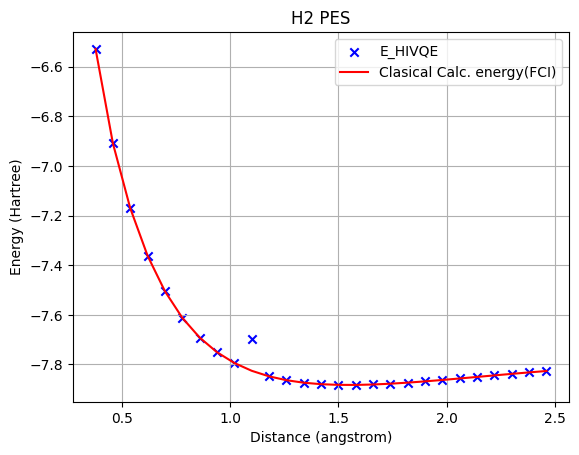

In [10]:
def FCI(dist):
    # 1. 분자 정의
    mol = gto.M(
        atom = 'Li 0 0 0; H 0 0 {}'.format(dist),  # 수소 원자 2개, 거리 0.74 Å
        basis = 'sto-3g',              # 간단한 기저함수
        unit = 'Angstrom',
        spin = 0,                      # 전자 수 = 2, 총 spin = 0 (singlet)
        charge = 0
    )

    # 2. Hartree-Fock 계산
    mf = scf.RHF(mol)
    hf_energy = mf.kernel()

    # 3. FCI 계산 (Full CI)
    cisolver = fci.FCI(mol, mf.mo_coeff)
    fci_energy, fci_vector = cisolver.kernel()

    return fci_energy

    # 4. 결과 출력
    #print(f"Hartree–Fock Energy: {hf_energy:.10f} Hartree")
    #print(f"FCI Ground State Energy: {fci_energy:.10f} Hartree")



x = np.arange(0.3, 2.5, 0.08)
E_VQE = []
E_FCI = []
for dist in x:
    atoms = ["Li", "H"]
    basis = 'sto-3g'
    coords = [(0,0,0), (dist,0,0)]
    charge = 0
    multiplicity = 1

    Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
    driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
    E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 
    e_vqe = HIVQE(E_problem, 30, E_FCI, False, False)
    e_fci = FCI(dist)

    E_VQE.append(e_vqe)
    E_FCI.append(e_fci)



plt.scatter(x[1:], E_VQE[1:], marker='x',color='blue', label="E_HIVQE")
plt.plot(x[1:], E_FCI[1:], color='red', label="Clasical Calc. energy(FCI)")

plt.xlabel("Distance (angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.title("H2 PES")
plt.grid()
plt.show()